<a href="https://colab.research.google.com/github/pritika-vig/MLHC-AgentBasedROI/blob/main/notebooks/200_WSIs_and_Annotations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install required tools
!apt-get update
!apt-get install -y openslide-tools
!pip install openslide-python
!pip install awscli --quiet

Get:1 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:2 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:3 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:4 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:6 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Hit:7 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:9 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:11 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [2,737 kB]
Get:12 http://security.ubuntu.com/ubuntu jammy-security/multiverse amd64 Packages [47.7 kB]
Get:13 http://security.ubuntu.com/ubuntu jammy-securi

Verify you are connecting to the public AWS bucket correctly. Running the following code snippet should produce: PRE CAMELYON16/ PRE CAMELYON17/

In [2]:
!aws s3 ls --no-sign-request s3://camelyon-dataset/


                           PRE annotations/
                           PRE background_tissue/
                           PRE evaluation/
                           PRE images/
                           PRE masks/
2022-09-28 09:15:16          0 
2022-09-28 09:16:24       3642 README.md
2022-09-28 09:16:56      55360 checksums.md5
2022-09-28 12:27:44       7260 license.txt
2022-09-28 12:32:09        407 pathology-tissue-background-segmentation.json


Download WSIs and their corresponding annotations.

In [17]:
import os
import subprocess
import random

# Set these as you like. Downloading 5 tumors and 5 normal took ~12 minutes for me (pritikav).
NUMBER_OF_TUMORS_TO_DOWNLOAD = 5
NUMBER_OF_NORMAL_TO_DOWNLOAD = 5

# Create folders
os.makedirs("wsis", exist_ok=True)
os.makedirs("annotations", exist_ok=True)

# Base paths
image_base = "s3://camelyon-dataset/CAMELYON16/images/"
annotation_base = "s3://camelyon-dataset/CAMELYON16/annotations/"

# Simulate IDs (these may go higher depending on what's available)
tumor_ids = [f"tumor_{i:03d}" for i in range(1, 400)]
normal_ids = [f"normal_{i:03d}" for i in range(1, 400)]

# Shuffle and choose 100 random tumor + 100 random normal
random.shuffle(tumor_ids)
random.shuffle(normal_ids)

selected_tumors = []
selected_normals = []
total_files_attempted = 0

def try_download(image_id, annotation_name):
    total_files_attempted += 1
    image_name = f"{image_id}.tif"
    annotation_file = f"{annotation_name}.xml"
    image_dst = f"wsis/{image_name}"
    annotation_dst = f"annotations/{annotation_file}"

    # Download image
    result_img = subprocess.run([
        "aws", "s3", "cp", "--no-sign-request",
        image_base + image_name, image_dst
    ], stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)

    # Download annotation
    result_ann = subprocess.run([
        "aws", "s3", "cp", "--no-sign-request",
        annotation_base + annotation_file, annotation_dst
    ], stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)

    return result_img.returncode == 0 and result_ann.returncode == 0

print("📥 Downloading 100 tumor WSIs with annotations...")
for tumor_id in tumor_ids:
    annotation_name = tumor_id  # tumor images have matching annotation filenames
    if try_download(tumor_id, annotation_name):
        selected_tumors.append(tumor_id)
        print(f"Tumor: {tumor_id}")
    if len(selected_tumors) >= NUMBER_OF_TUMORS_TO_DOWNLOAD:
        break

print("\n📥 Downloading 100 normal WSIs with annotations...")
for normal_id in normal_ids:
    # Normal images seem to use "test_xxx.xml" annotations
    test_num = normal_id.split('_')[1]
    annotation_name = f"test_{test_num}"
    if try_download(normal_id, annotation_name):
        selected_normals.append(normal_id)
        print(f"Normal: {normal_id}")
    if len(selected_normals) >= NUMBER_OF_NORMAL_TO_DOWNLOAD:
        break

print(f"\nDownloaded {len(selected_tumors)} tumor and {len(selected_normals)} normal WSI/annotation pairs.")
print(f"Total files attempted: {total_files_attempted}")

📥 Downloading 100 tumor WSIs with annotations...
Tumor: tumor_017
Tumor: tumor_058
Tumor: tumor_056
Tumor: tumor_011
Tumor: tumor_105

📥 Downloading 100 normal WSIs with annotations...
Normal: normal_040
Normal: normal_011
Normal: normal_074
Normal: normal_079
Normal: normal_116

Downloaded 5 tumor and 5 normal WSI/annotation pairs.


Display a randomly chosen WSI and it's annotation.


Visualizing: tumor_056
Regions found: 31
Total vertices: 16952
Polygons drawn: True


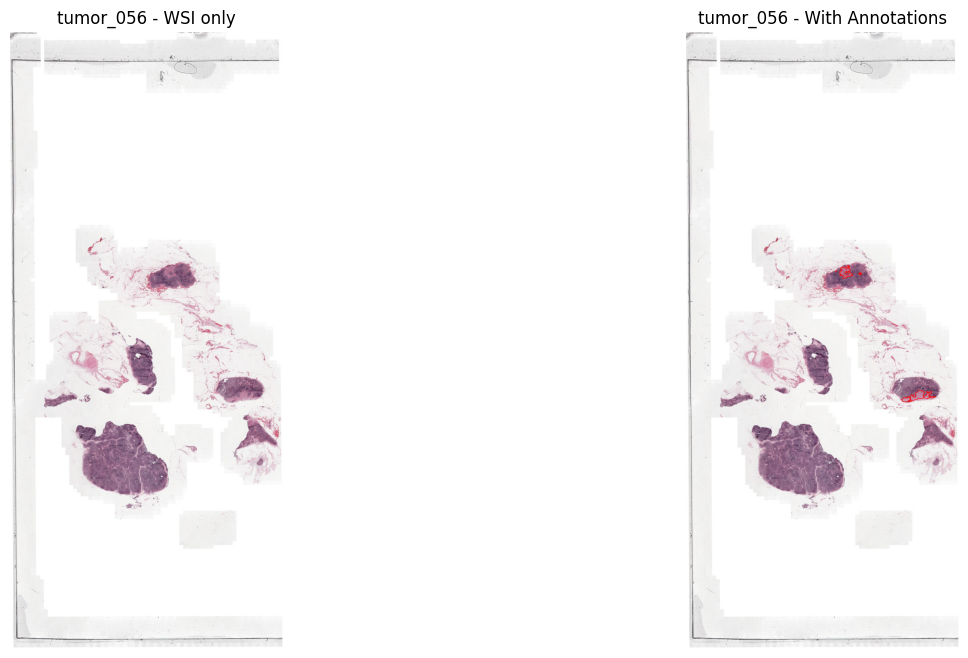

In [18]:
import random
import xml.etree.ElementTree as ET
import openslide
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw


# Pick a random slide
random_id = random.choice(selected_tumors)
wsi_path = f"wsis/{random_id}.tif"
xml_path = f"annotations/{random_id}.xml"

print(f"\nVisualizing: {random_id}")
slide = openslide.OpenSlide(wsi_path)

# Get WSI dimensions and create a thumbnail
wsi_w, wsi_h = slide.dimensions
thumb_size = (1024, int(1024 * wsi_h / wsi_w))
thumb = slide.get_thumbnail(thumb_size)
thumb_with_ann = thumb.copy()
draw = ImageDraw.Draw(thumb_with_ann)

# Scale factors for mapping original coordinates to thumbnail
x_scale = thumb_size[0] / wsi_w
y_scale = thumb_size[1] / wsi_h

# Parse the annotation XML
tree = ET.parse(xml_path)
root = tree.getroot()

# Parse and draw annotations using ASAP-style XML
annotations_tag = root.find("Annotations")

region_count = 0
vertex_count = 0
polygon_drawn = False

if annotations_tag is not None:
    for annotation in annotations_tag.findall("Annotation"):
        coords_tag = annotation.find("Coordinates")
        coords = []
        if coords_tag is not None:
            for coord in coords_tag.findall("Coordinate"):
                x = float(coord.attrib['X']) * x_scale
                y = float(coord.attrib['Y']) * y_scale
                coords.append((x, y))
                vertex_count += 1
            if coords:
                draw.polygon(coords, outline="red", width=2)
                polygon_drawn = True
                region_count += 1


print(f"Regions found: {region_count}")
print(f"Total vertices: {vertex_count}")
print(f"Polygons drawn: {polygon_drawn}")

# Display the WSI and WSI+annotation
fig, axs = plt.subplots(1, 2, figsize=(16, 8))

axs[0].imshow(thumb)
axs[0].set_title(f"{random_id} - WSI only")
axs[0].axis("off")

axs[1].imshow(thumb_with_ann)
axs[1].set_title(f"{random_id} - With Annotations")
axs[1].axis("off")

plt.show()